# Convolution neural network classification of dogs vs. cats with Keras and Tensorflow

In [1]:
# Special thanks to:
#    https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
#    https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d
#    https://www.kaggle.com/sarvajna/dogs-vs-cats-keras-solution/

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keras (from TensorFlow) imports for the dataset and building NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import image_data_format
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import zipfile
import os

# Image processing library - pip3 install opencv-python
import cv2

In [3]:
# unzip archive with 1000 dogs and 1000 cats
animals_archive = 'cats_vs_dogs.zip'
animals_dir = 'cats_vs_dogs'
animals_dir_out = 'cats_vs_dogs_out'

if not os.path.exists(animals_dir):
    with zipfile.ZipFile(animals_archive, 'r') as zip_ref:
        zip_ref.extractall('.')
        
if not os.path.exists(animals_dir_out):
    os.makedirs(animals_dir_out)

In [4]:
# load image names
animal_images = [file for file in os.listdir(animals_dir)]
print("Loaded images: ", len(animal_images))

# scale images to the following dimensions
img_width = 150
img_height = 150

def convert_images(list_of_images):
    x = [] # images as 4-dim arrays
    y = [] # labels
    
    for image_name in list_of_images:
        image_path = os.path.join(animals_dir, image_name)
        # print('Processing', image_path)
        img = cv2.resize(cv2.imread(image_path), (img_width, img_height), interpolation=cv2.INTER_CUBIC)
        x.append(img)
        y.append(1 if 'dog' in image_name else 0) # dog else cat
        
        # store converted file for manual verification
        cv2.imwrite(os.path.join(animals_dir_out, image_name), img)
            
    return x, y

print('Converting images...')
scaled_animal_images, animal_labels = convert_images(animal_images)
print('Done.')

Loaded images:  2000
Converting images...
Done.


In [5]:
if image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
print('Input shape: ', input_shape)

Input shape:  (150, 150, 3)


In [6]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(scaled_animal_images, animal_labels, test_size=0.05, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

1900 100 1900 100


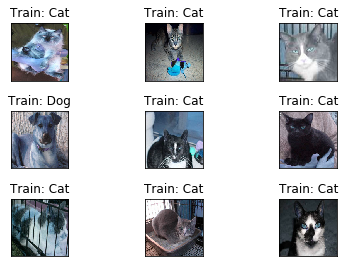

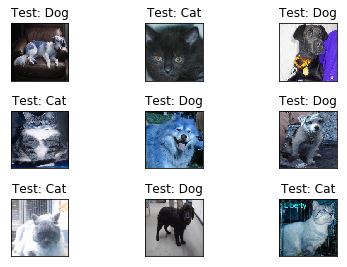

In [7]:
# Draw first several figures for train set
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Train: {}".format('Dog' if y_train[i] == 1 else 'Cat' ))
  plt.xticks([])
  plt.yticks([])
    
# Draw first several figures for test set
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_test[i], interpolation='none')
  plt.title("Test: {}".format('Dog' if y_test[i] == 1 else 'Cat' ))
  plt.xticks([])
  plt.yticks([])

In [8]:
# convert train/test output data into 2 categories - dog vs. cat
num_classes = 2
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)
print('Y_train:', Y_train.shape)
print('Y_test:', Y_test.shape)

Y_train: (1900, 2)
Y_test: (100, 2)


In [9]:
# prepare generators of scaled images for learning process
batch_size = 10

train_img_data_gen = ImageDataGenerator(
    rescale=1.0 / 255)

# only rescaling
test_img_data_gen = ImageDataGenerator(
    rescale=1.0 / 255)

train_generator = train_img_data_gen.flow(np.array(X_train), Y_train, batch_size=batch_size)
test_generator = test_img_data_gen.flow(np.array(X_test), Y_test, batch_size=batch_size)

In [10]:
# define CNN model for animal images classification
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

In [11]:
# learn NN
epochs = 30

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

# avoid validation now
#    validation_data=test_generator,
#    validation_steps=len(X_test) // batch_size)

Epoch 1/30
190/190 [==============================] - 58s 303ms/step - loss: 0.6954 - accuracy: 0.5411
Epoch 2/30
190/190 [==============================] - 60s 313ms/step - loss: 0.6149 - accuracy: 0.6621
Epoch 3/30
190/190 [==============================] - 60s 313ms/step - loss: 0.5519 - accuracy: 0.7253
Epoch 4/30
190/190 [==============================] - 60s 314ms/step - loss: 0.4982 - accuracy: 0.7653
Epoch 5/30
190/190 [==============================] - 60s 315ms/step - loss: 0.4501 - accuracy: 0.7974
Epoch 6/30
190/190 [==============================] - 60s 314ms/step - loss: 0.4115 - accuracy: 0.8095
Epoch 7/30
190/190 [==============================] - 60s 314ms/step - loss: 0.3630 - accuracy: 0.8379
Epoch 8/30
190/190 [==============================] - 62s 328ms/step - loss: 0.3139 - accuracy: 0.8705
Epoch 9/30
190/190 [==============================] - 69s 361ms/step - loss: 0.2670 - accuracy: 0.8942
Epoch 10/30
190/190 [==============================] - 66s 346ms/step - l

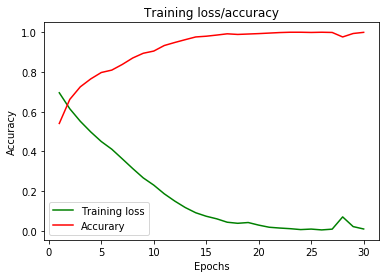

In [12]:
history_dict = history.history

loss_values = history_dict['loss']
accuracy_values = history_dict['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b', label='Training loss', color='green')
plt.plot(epochs, accuracy_values, 'b', label='Accurary', color='red')

plt.title('Training loss/accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
_, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print('Test data accuracy: ', test_acc)

Test data accuracy:  0.71


In [14]:
prediction_probabilities = model.predict_generator(test_generator, verbose=1)

10/10 [==============================] - 1s 74ms/step


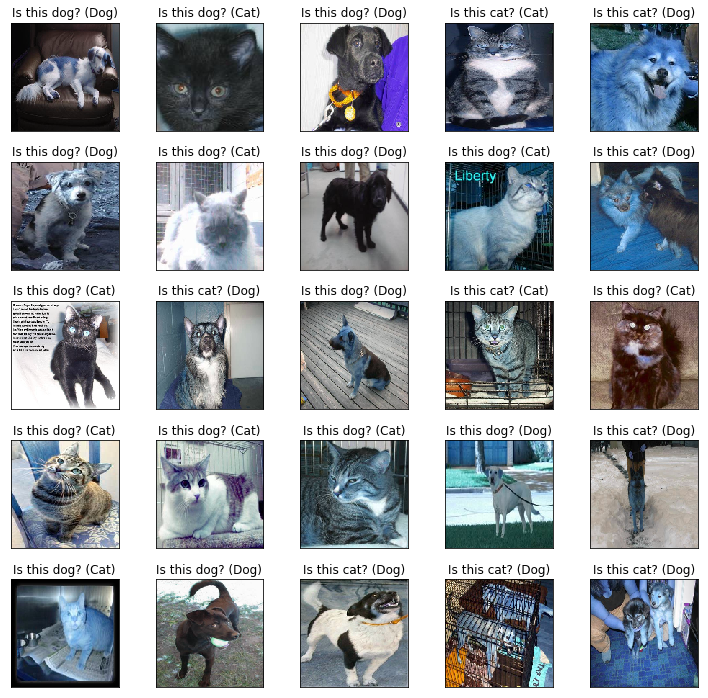

In [15]:
# convert predictions to classes
Y_test_classes = list(np.argmax(prediction_probabilities, axis=1))


# Draw first several figures for test set
fig = plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(X_test[i], interpolation='none')
  plt.title("Is this {}? ({})".format('dog' if Y_test_classes[i] == 1 else 'cat', 'Dog' if y_test[i] == 1 else 'Cat'))
  plt.xticks([])
  plt.yticks([])